In [1]:
# import required libraries

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=10,6

from pandas import set_option
#set_option('precision',5)
pd.options.display.float_format = '{:.5f}'.format

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Import Libraries and packages from tensorflow.Keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

In [2]:
# read the data

dataset = pd.read_csv('US_Gold_stockdata2008.csv',index_col='Date',parse_dates=True,infer_datetime_format=True)

In [3]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-12-31,843.20001,843.20001,843.20001,834.90002,834.90002,4.00000
2008-01-02,848.70001,857.79999,846.40002,857.00000,857.00000,130.00000
2008-01-03,863.00000,865.50000,856.29999,866.40002,866.40002,181.00000
2008-01-04,861.40002,865.50000,860.20001,863.09998,863.09998,28.00000
2008-01-06,nan,nan,nan,nan,nan,nan


In [4]:
# drop null values and Volume column

dataset.dropna(axis = 0, inplace = True) 
dataset.drop(['Volume','Adj Close'], axis = 1, inplace = True) 

In [5]:
dataset.head()

,Open,High,Low,Close
Date,,,,
2007-12-31,843.20001,843.20001,843.20001,834.90002
2008-01-02,848.70001,857.79999,846.40002,857.00000
2008-01-03,863.00000,865.50000,856.29999,866.40002
2008-01-04,861.40002,865.50000,860.20001,863.09998
2008-01-07,860.90002,860.90002,857.40002,859.59998


In [6]:
datelist = dataset.index
datelist[:5]

DatetimeIndex(['2007-12-31', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-07'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [7]:
print(f"Training set shape: {dataset.shape}")
print(f"Date list shape: {datelist.shape}")
print(f"Features in training set: {dataset.columns}")

Training set shape: (3317, 4)
Date list shape: (3317,)
Features in training set: Index(['Open', 'High', 'Low', 'Close'], dtype='object')


C:\Users\DELL\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


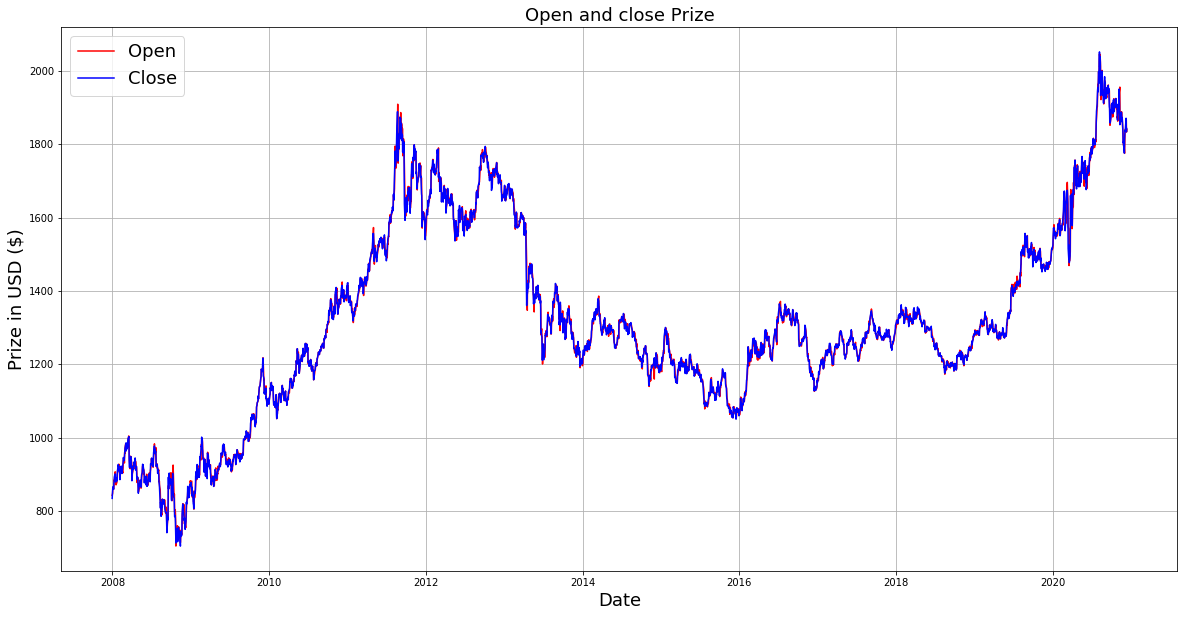

In [8]:
# visualization

plt.figure(figsize=(20,10))
plt.title('Open and close Prize', fontsize=18)
plt.plot(dataset['Open'], label = 'Open', color = 'r')
plt.plot(dataset['Close'], label = 'Close', color = 'b')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prize in USD ($)', fontsize=18)
plt.legend( fontsize=18)
plt.grid()
plt.show()

In [9]:
# creating dataset 

data_close = dataset.filter(['Close'])

data = data_close.values # convert it into array

training_data_len = math.ceil(len(data) * .8) # no of rows o train the model on

training_data_len

2654

In [10]:
# scale the data

scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(data)

scaled_data

array([[0.09653943],
       [0.11295112],
       [0.11993168],
       ...,
       [0.83892765],
       [0.83818504],
       [0.84494278]])

In [11]:
train_data = scaled_data[0:training_data_len, :]

X_train = []
y_train = []

for i in range(60,len(train_data)):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    
    if i<=60:
        print(X_train)
        print(y_train)

[array([0.09653943, 0.11295112, 0.11993168, 0.11748103, 0.11488189,
       0.12854595, 0.12965987, 0.13871973, 0.14198719, 0.14607155,
       0.14562601, 0.13047672, 0.12965987, 0.13062525, 0.13716022,
       0.1318877 , 0.14896776, 0.15268081, 0.16500814, 0.16352291,
       0.16018116, 0.16174067, 0.15134412, 0.14852221, 0.1344126 ,
       0.14540323, 0.1494133 , 0.15854746, 0.16188921, 0.15037873,
       0.14971037, 0.15037873, 0.1469627 , 0.16463683, 0.17057772,
       0.17911775, 0.17807812, 0.17280555, 0.17911775, 0.18810337,
       0.19278181, 0.19842563, 0.20540619, 0.19233626, 0.20889647,
       0.20057922, 0.19849992, 0.19679192, 0.19998514, 0.20340114,
       0.21342638, 0.21780781, 0.22018417, 0.22152086, 0.17807812,
       0.15943855, 0.15847317, 0.17057772, 0.18127134, 0.1811228 ])]
[0.16760727463431946]


In [12]:
# convert it into numpy array

X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
# reshape the data
# As LSTM expects the data to be in 3 dimentional

print(X_train.shape)

X_train = np.reshape(X_train, (X_train.shape[0],60,1))

print(X_train.shape)

(2594, 60)
(2594, 60, 1)


In [14]:
# preparing testing data 

test_data = scaled_data[training_data_len-60:, :]

# create X_test and y_test

X_test = []
y_test = data[training_data_len:, :]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [15]:
# convert into numpy array

X_test = np.array(X_test)

In [16]:
print(X_test.shape)

(663, 60)


In [29]:
# reshape the data

print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)

(663, 60, 1)
(663, 60, 1)


In [30]:
# build the LSTM model

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [31]:
# compile the model

model.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error')

In [32]:
# train the model

history = model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
21/21 [==============================] - 2s 87ms/step - loss: 0.0322
Epoch 2/10
21/21 [==============================] - 2s 101ms/step - loss: 0.0021
Epoch 3/10
21/21 [==============================] - 2s 96ms/step - loss: 5.0347e-04
Epoch 4/10
21/21 [==============================] - 2s 91ms/step - loss: 3.8506e-04
Epoch 5/10
21/21 [==============================] - 2s 97ms/step - loss: 3.8795e-04
Epoch 6/10
21/21 [==============================] - 2s 93ms/step - loss: 3.6431e-04
Epoch 7/10
21/21 [==============================] - 2s 93ms/step - loss: 3.4371e-04
Epoch 8/10
21/21 [==============================] - 2s 100ms/step - loss: 3.4016e-04
Epoch 9/10
21/21 [==============================] - 2s 92ms/step - loss: 3.1675e-04
Epoch 10/10
21/21 [==============================] - 2s 91ms/step - loss: 3.2335e-04


In [33]:
# get the models predicted values

predictions = model.predict(X_test)

# reverse transform

predictions = scaler.inverse_transform(predictions)

In [34]:
# Get the RMSE and MSE

rmse = np.sqrt(np.mean(predictions - y_test)**2 )
print(f"RMSE: {rmse}")

RMSE: 1.5692700401348059


C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


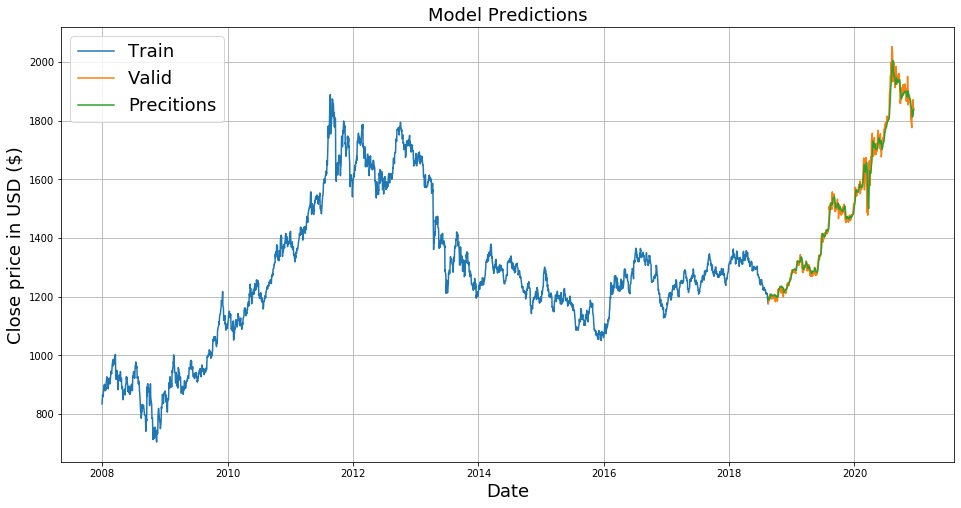

In [35]:
# plot the data

train = data_close[:training_data_len]
valid = data_close[training_data_len:]
valid['Precitions'] = predictions

# visualize the data

plt.figure(figsize=(16,8))
plt.title("Model Predictions",fontsize = 18)

plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close price in USD ($)', fontsize = 18)

plt.plot(train['Close'], label = "Train")
plt.plot(valid['Close'], label = "Valid")
plt.plot(valid['Precitions'], label = "Precitions")
plt.legend(fontsize = 18)
plt.grid()
plt.show()

In [36]:
# show the valid prices

valid

,Close,Precitions
Date,,
2018-08-17,1176.50000,1198.12476
2018-08-20,1186.80005,1192.66821
2018-08-21,1192.59998,1189.81018
2018-08-22,1196.30005,1189.51611
2018-08-23,1187.00000,1191.10291
...,...,...
2020-12-07,1861.80005,1815.37317
2020-12-08,1870.80005,1822.08301
2020-12-09,1834.59998,1830.98291
